<a href="https://colab.research.google.com/github/SakshiDawale26/ML-and-AI_Projects/blob/main/Regration_project03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

# Set plot style
sns.set_style('whitegrid')

Data Loading via kaggle API

In [10]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"dawalesakshi","key":"2cb010381b203535d3a3caa2152e88ac"}'}

In [16]:
!mv "kaggle (3).json" kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")


Kaggle API configured successfully.


In [18]:
!kaggle competitions files -c house-prices-advanced-regression-techniques
!kaggle competitions download -c house-prices-advanced-regression-techniques -p ./house_prices
!unzip -o ./house_prices/house-prices-advanced-regression-techniques.zip -d ./house_prices


name                         size  creationDate                
---------------------  ----------  --------------------------  
data_description.txt        13370  2019-12-15 21:33:33.301000  
sample_submission.csv       31939  2019-12-15 21:33:33.301000  
test.csv                   451405  2019-12-15 21:33:33.301000  
train.csv                  460676  2019-12-15 21:33:33.301000  
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 531MB/s]
Archive:  ./house_prices/house-prices-advanced-regression-techniques.zip
  inflating: ./house_prices/data_description.txt  
  inflating: ./house_prices/sample_submission.csv  
  inflating: ./house_prices/test.csv  
  inflating: ./house_prices/train.csv  


In [20]:
!ls ./house_prices


data_description.txt				 test.csv
house-prices-advanced-regression-techniques.zip  train.csv
sample_submission.csv


In [22]:
import os
print(os.getcwd())



/content


In [23]:
!find /content -name "train.csv"
!find /content -name "test.csv"


/content/house_prices/train.csv
/content/house_prices/test.csv


In [25]:
import pandas as pd

train_df = pd.read_csv("/content/house_prices/train.csv")
test_df  = pd.read_csv("/content/house_prices/test.csv")

train_df.set_index("Id", inplace=True)
test_df.set_index("Id", inplace=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)



Train shape: (1460, 80)
Test shape: (1459, 79)


In [26]:
print("Data loaded successfully:")
train_df.head()

Data loaded successfully:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Deep dive EDA on the Target Variable


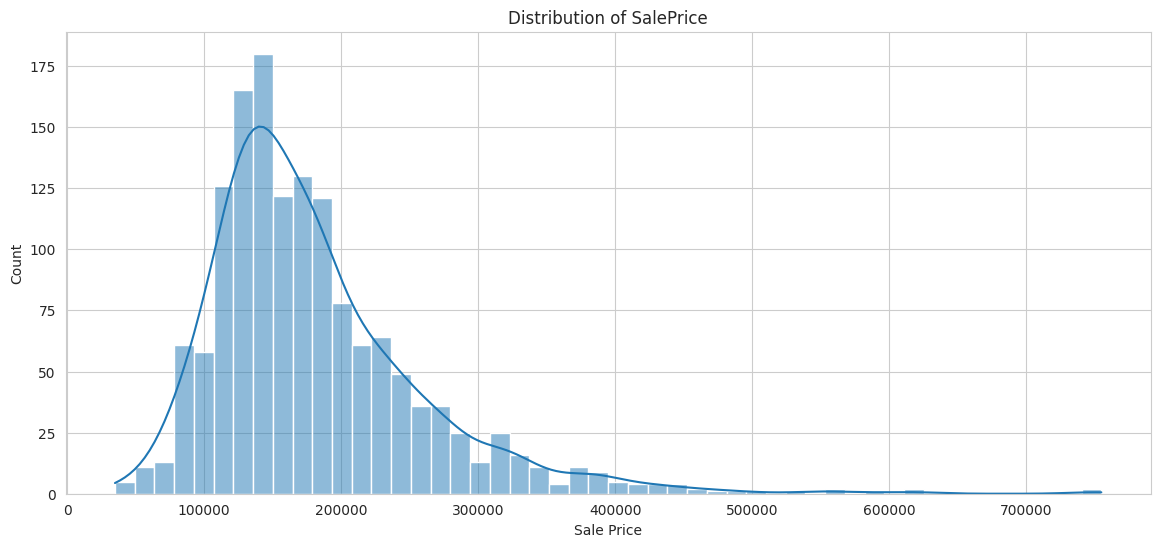

Skewness of SalePrice: 1.8828757597682129


In [27]:
plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

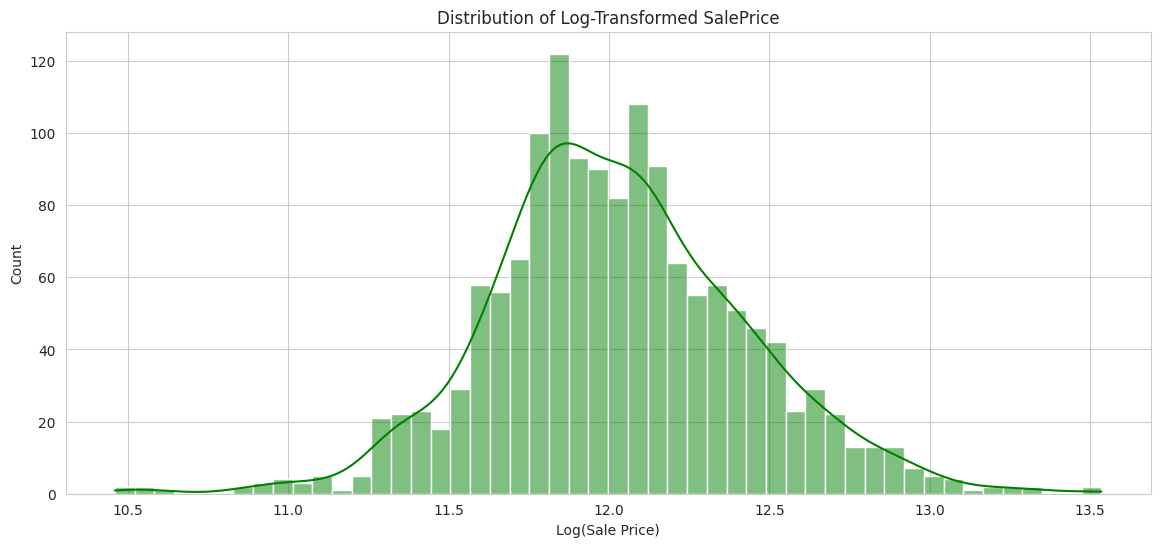

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [28]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

EDA on Feature Variables


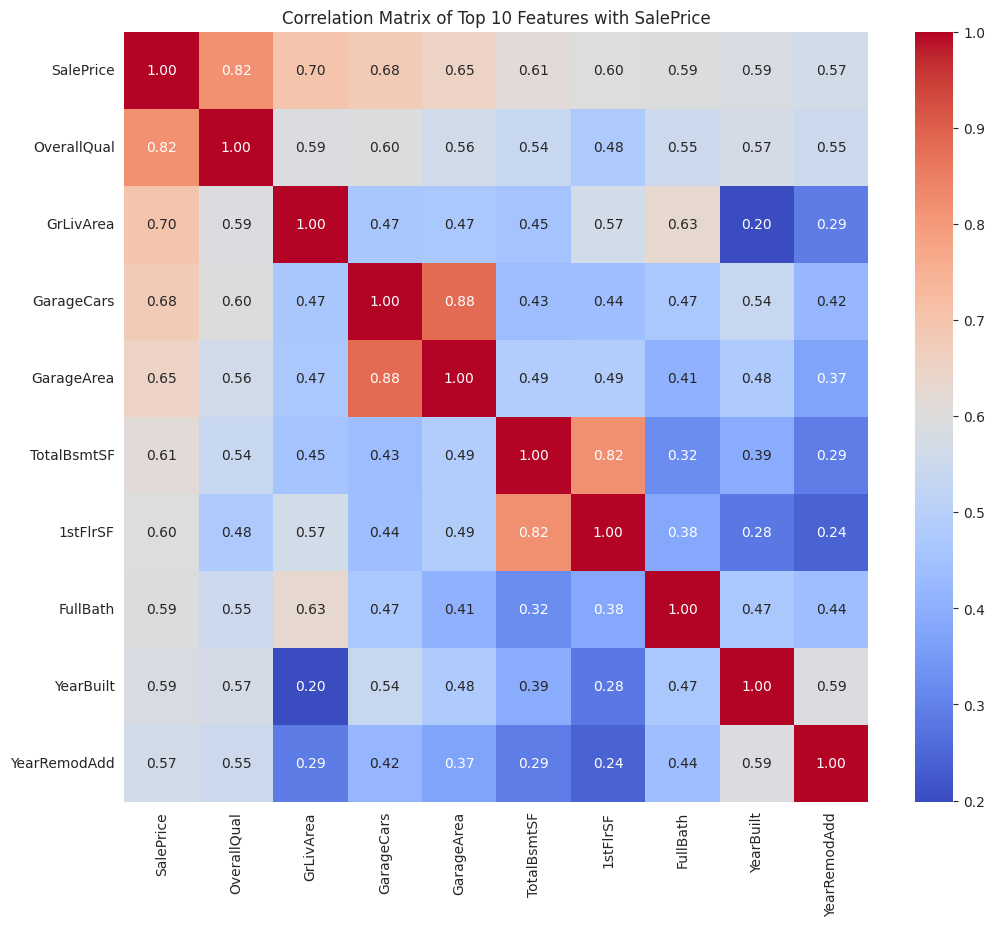

In [29]:
# Find the top 10 features most correlated with SalePrice
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

Deep Preprocessinf & Feature Engineering

In [30]:
# Combine train and test data for consistent preprocessing
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


Handling missing values

In [31]:
# Find missing values in the current all_data
missing_data = all_data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print("Features with missing values:")
print(missing_data)

Features with missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [32]:
# Impute numerical features with 0
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [33]:
# Check missing values in numerical columns after imputation with 0
all_data[numerical_cols_to_impute_zero].isnull().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [34]:
all_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,276
80.0,137
70.0,133
50.0,117
75.0,105
...,...
155.0,1
126.0,1
200.0,1


In [35]:
# Impute LotFrontage with the median of the neighborhood
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isnull().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [36]:
all_data['Alley'].value_counts()

,count
Alley,
Grvl,120
Pave,78


In [37]:
all_data['Electrical']

,Electrical
Id,
1,SBrkr
2,SBrkr
3,SBrkr
4,SBrkr
5,SBrkr
...,...
2915,SBrkr
2916,SBrkr
2917,SBrkr


In [38]:
# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [39]:
# Based on the likely remaining missing values (GarageYrBlt), impute the remaining numerical features.
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isnull().sum().sum())


Missing values after all imputation: 0


Feature Fngineering

In [40]:
# Create a total square footage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Create a total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


Categorical Encoding

In [41]:
all_data['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,443
CollgCr,267
OldTown,239
Edwards,194
Somerst,182
NridgHt,166
Gilbert,165
Sawyer,151
NWAmes,131


In [42]:
#Convert any remaining object columns to category type for one-hot encoding
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {all_data.shape}")

Data shape after encoding: (2919, 262)


Model Building & Trainig


In [43]:
# Separate the preprocessed data back into training and testing sets
X = all_data[:len(train_df)]
y = train_df['SalePrice'] # SalePrice was already log-transformed and is only in train_df
X_test_final = all_data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [45]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,False,False,False,False,True,False,False,False,True,False
1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,False,False,False,False,True,False,False,False,True,False


Linear Regration (BaseLine)

In [46]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

XGBoost

In [47]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

Model Evaluation

In [48]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

# evaluate_model(y_val, y_pred_lr, "Linear Regression") # Commenting out Linear Regression evaluation as it failed
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- XGBoost Performance ---
RMSE: 0.1315
MAE:  0.0858
R-squared: 0.9073



Submission File

In [49]:
# Make predictions on the final test set using the best model (XGBoost)
# Use the unscaled test data for XGBoost prediction
final_predictions_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,125996.656250
1,1462,166337.156250
2,1463,187915.328125
3,1464,197955.718750
4,1465,182225.312500


from matplotlib import pyplot as plt
_df_0['Id'].plot(kind='hist', bins=20, title='Id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['SalePrice'].plot(kind='hist', bins=20, title='SalePrice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Id', y='SalePrice', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Id']
  ys = series['SalePrice']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('SalePrice')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Id'}, axis=1)
              .sort_values('Id', ascending=True))
  xs = counted['Id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Id'].plot(kind='line', figsize=(8, 4), title='Id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['SalePrice'].plot(kind='line', figsize=(8, 4), title='SalePrice')
plt.gca().spines[['top', 'right']].set_visible(False)

In [50]:
print("Missing values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Missing values in X_val_scaled:", np.isnan(X_val_scaled).sum())

Missing values in X_train_scaled: 0
Missing values in X_val_scaled: 0


In [51]:
print("Infinite values in X_train_scaled:", np.isinf(X_train_scaled).sum())
print("Infinite values in X_val_scaled:", np.isinf(X_val_scaled).sum())

Infinite values in X_train_scaled: 0
Infinite values in X_val_scaled: 0


In [55]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute MSE
mse = mean_squared_error(y_valid, y_pred)

# Take square root for RMSE
rmse = np.sqrt(mse)
print("Validation RMSE:", rmse)


Validation RMSE: 36836.908845840895
